# Carrier-depletion phase modulator

Tidy3D capabilities include the modeling of material properties perturbations due to presence of free carriers. This provides a convenient way to perform full-wave simulations of electro-optic modulators. In this notebook we demonstrate simulation of a simple pn-junction electro-optic modulator as part of an MZI. For generating free carrier distributions under different voltages we use an open-source package `devsim`.

## Problem Parameters

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
from tidy3d import web
import gdstk

import devsim
from devsim.python_packages import model_create, simple_physics

Our simulation setup will consist of an MZI with two arms, one of which is has a common pin-junction profile. For combiner and spitter of the signal we use waveguide couplers. The overall geometry and notation used is shown in the following figure.

<img src="img/pn_mzi_cross.png" alt="Modulator Cross-Section"  width="500"/>

<img src="img/pn_mzi_circuit.png" alt="Scheme of MZI Circuit"  width="800"/>

In [2]:
# modulator cross section parameters
w_core = 0.5
h_core = 0.22
h_slab = 0.09
h_side = 0.22
w_contact = 0.45
x_side = 1.5
x_total = 2
x_i = 0.1
x_p = 1.25
h_contact = 0.01

# modulator doping concentrations
conc_p=7e17
conc_pp=13e17
conc_n=5e17
conc_nn=25e17

# photoc circuit geometric paramters
couple_gap = 0.1
couple_length = 10
couple_wg_in = 10
couple_wg_out = 1
bend_length = 10
wg_spacing = 5
taper_length = 10
wg_length = 100


Auxiliary variable for easier construction of simulations.

In [3]:
mzi_length = 2 * taper_length + wg_length
splitter_length = couple_length + 2 * bend_length + 2 * couple_wg_out
x_splitter = (mzi_length + splitter_length) / 2

z_core = h_core / 2
z_slab = h_slab / 2
z_side = h_side / 2

## Carrier Distribution

For convenience, we implement a function that uses `devsim` to generate electron and hole concentrations in the 2d geometry corresponding to the cross section of the modulator used in this example. It takes in parameters of the cross section profile and voltages to solve at, and returns electron and hole distributions for each requested voltage.

In [4]:
from typing import Tuple

def solve_charge(
    w_core: float, 
    h_core: float, 
    h_slab: float, 
    h_side: float, 
    w_contact: Tuple[float, float], 
    h_contact: float,
    x_side: Tuple[float, float], 
    x_total: Tuple[float, float], 
    x_i: Tuple[float, float],
    x_p: Tuple[float, float],
    conc_p: float,
    conc_pp: float,
    conc_n: float,
    conc_nn: float,
    voltages: Tuple[float],
    res: float,
    center: Tuple[float, float, float],
    axis: float,
):
    """
    This function generates electron and hole distributions in a pn (pin) waveguide cross-section.

    Parameters
    ----------
    w_core: width of core region (um)
    h_core: height of core region (um)
    h_slab: height of slab (um) 
    h_side: height of side regions (um)
    w_contact: widths (2) of metal contacts (um)
    h_contact: height of metal contacts (um)
    x_side: distances (2) from modulator center to side ribs (um)  
    x_total: total extents (2) of device in horizontal direction (um) 
    x_i: distances (2) from modulator center to boundaries of lightly doped regions (um)
    x_p: distances (2) from modulator center to boundaries of heavy doped regions (um)
    conc_p: hole concentration of lightly doped region (1/cm^3)
    conc_pp: hole concentration of heavy doped region (1/cm^3)
    conc_n: electron concentration of lightly doped region (1/cm^3)
    conc_nn: electron concentration of heavy doped region (1/cm^3)
    voltages: list of voltages to solve for (V)
    res: spatial resolution (um)
    center: coordinate of modulator base (um)
    axis: modulator orientation in space
    """
    device_name = "pin_wg"
    mesh_name = "pin_wg_mesh"

    # convert size into cm
    um_to_cm = 1e-4
    
    w_core_cm = w_core * um_to_cm
    h_core_cm = h_core * um_to_cm
    h_slab_cm = h_slab * um_to_cm
    h_side_cm = h_side * um_to_cm
    w_contact_cm = [w_contact[0] * um_to_cm, w_contact[1] * um_to_cm]
    h_contact_cm = h_contact * um_to_cm
    x_side_cm = [x_side[0] * um_to_cm, x_side[1] * um_to_cm]
    x_total_cm = [x_total[0] * um_to_cm, x_total[1] * um_to_cm]
    
    x_i_cm = [x_i[0] * um_to_cm, x_i[1] * um_to_cm]
    x_p_cm = [x_p[0] * um_to_cm, x_p[1] * um_to_cm]
    
    res_cm = res * um_to_cm

    # tolerance for defining 
    tol = res_cm * 1e-3

    # we will expanded device dimensions by a small amount to make sure that numerical round-off
    # errors do not cause interpolation errors near device boundaries when transferring 
    # data from charge solver to opitc solver
    expand = tol / 10

    # create mesh
    devsim.create_2d_mesh(mesh=mesh_name)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=0 - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_slab_cm + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_core_cm + expand, ps=res_cm)
    if h_side != h_core and h_side != h_slab:
        devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_side_cm + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="y", pos=h_side_cm + h_contact_cm, ps=res_cm)
        
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[0] - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[1] + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_side_cm[0] + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_side_cm[1] - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=-w_core_cm / 2 - expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=w_core_cm / 2 + expand, ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[0] + w_contact_cm[0], ps=res_cm)
    devsim.add_2d_mesh_line(mesh=mesh_name, dir="x", pos=x_total_cm[1] - w_contact_cm[1], ps=res_cm)

    devsim.add_2d_region(mesh=mesh_name, material="Si", region="core", xl=-w_core_cm / 2, xh=w_core_cm / 2, yl=0, yh=h_core_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="slab_left", xl=x_side_cm[0], xh=-w_core_cm / 2, yl=0, yh=h_slab_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="slab_right", xl=w_core_cm / 2, xh=x_side_cm[1], yl=0, yh=h_slab_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="side_left", xl=x_total_cm[0], xh=x_side_cm[0], yl=0, yh=h_side_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="Si", region="side_right", xl=x_side_cm[1], xh=x_total_cm[1], yl=0 , yh=h_side_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="metal", region="metal_right", xl=x_total_cm[1] - w_contact_cm[1], xh=x_total_cm[1], yl=h_side_cm, yh=h_side_cm + h_contact_cm, bloat=tol)
    devsim.add_2d_region(mesh=mesh_name, material="metal", region="metal_left", xl=x_total_cm[0], xh=x_total_cm[0] + w_contact_cm[0], yl=h_side_cm, yh=h_side_cm + h_contact_cm, bloat=tol)
    
    devsim.add_2d_interface(mesh=mesh_name, name="side/slab", region0="side_left", region1="slab_left", xl=x_side_cm[0], xh=x_side_cm[0], yl=0, yh=h_slab_cm)
    devsim.add_2d_interface(mesh=mesh_name, name="slab/core", region0="slab_left", region1="core", xl=-w_core_cm / 2, xh=-w_core_cm / 2, yl=0, yh=h_slab_cm)
    devsim.add_2d_interface(mesh=mesh_name, name="core/slab", region0="core", region1="slab_right", xl=w_core_cm / 2, xh=w_core_cm / 2, yl=0, yh=h_slab_cm)
    devsim.add_2d_interface(mesh=mesh_name, name="slad/side", region0="slab_right", region1="side_right", xl=x_side_cm[1], xh=x_side_cm[1], yl=0, yh=h_slab_cm)
    
    devsim.add_2d_contact(mesh=mesh_name, name="left_contact", material="metal", region="side_left", yl=h_side_cm, yh=h_side_cm, xl=x_total_cm[0], xh=x_total_cm[0] + w_contact_cm[0], bloat=tol)
    devsim.add_2d_contact(mesh=mesh_name, name="right_contact", material="metal", region="side_right", yl=h_side_cm, yh=h_side_cm, xl=x_total_cm[1] - w_contact_cm[1], xh=x_total_cm[1], bloat=tol)

    devsim.finalize_mesh(mesh=mesh_name)
    devsim.create_device(mesh=mesh_name, device=device_name)

    # set material parameters
    simple_physics.SetSiliconParameters(device_name, "core", 300)
    simple_physics.SetSiliconParameters(device_name, "slab_left", 300)
    simple_physics.SetSiliconParameters(device_name, "slab_right", 300)
    simple_physics.SetSiliconParameters(device_name, "side_left", 300)
    simple_physics.SetSiliconParameters(device_name, "side_right", 300)

    # set doping
    p_expr = f"{conc_p:1.6e}*step({x_i_cm[0]:1.6e}-x) + {conc_pp:1.6e}*step({x_p_cm[0]:1.6e}-x)"
    n_expr = f"{conc_n:1.6e}*step(x-{x_i_cm[1]:1.6e}) + {conc_nn:1.6e}*step(x-{x_p_cm[1]:1.6e})"

    si_regions = ["core", "slab_left", "slab_right", "side_left", "side_right"]

    for region in si_regions:
        model_create.CreateNodeModel(device_name, region, "Acceptors", p_expr)
        model_create.CreateNodeModel(device_name, region, "Donors", n_expr)
        model_create.CreateNodeModel(device_name, region, "NetDoping", "Donors-Acceptors")
    
    # create physical models
    for region in si_regions:
        simple_physics.CreateSiliconPotentialOnly(device_name, region)
        
    simple_physics.CreateSiliconPotentialOnlyContact(device_name, "side_left", "left_contact")
    simple_physics.CreateSiliconPotentialOnlyContact(device_name, "side_right", "right_contact")
        
    for region in si_regions:        
        model_create.CreateSolution(device_name, region, "Electrons")
        model_create.CreateSolution(device_name, region, "Holes")

        # create initial guess from dc only solution
        devsim.set_node_values(device=device_name, region=region, name="Electrons", init_from="IntrinsicElectrons")
        devsim.set_node_values(device=device_name, region=region, name="Holes", init_from="IntrinsicHoles")

        # Set up equations
        simple_physics.CreateSiliconDriftDiffusion(device_name, region)

    simple_physics.CreateSiliconDriftDiffusionAtContact(device_name, "side_left", "left_contact")
    simple_physics.CreateSiliconDriftDiffusionAtContact(device_name, "side_right", "right_contact")
    
    devsim.set_parameter(device=device_name, name=simple_physics.GetContactBiasName("left_contact"), value="0.0")
    devsim.set_parameter(device=device_name, name=simple_physics.GetContactBiasName("right_contact"), value="0.0")

        
    for interface in devsim.get_interface_list(device=device_name):
        simple_physics.CreateSiliconSiliconInterface(
            device=device_name, interface=interface
        )

    # initial, zero bias solution
    devsim.solve(
        type="dc",
        absolute_error=1e8,
        relative_error=1e-8,
        maximum_iterations=100,
    )
    # return None, None

    normal_pos = center.pop(axis)

    electrons_datas = []
    holes_datas = []

    # iterate through and solve for each voltage
    for v in voltages:
        # set new voltage
        devsim.set_parameter(device=device_name, name=simple_physics.GetContactBiasName("left_contact"), value=f"{v:1.6e}")

        # solve
        devsim.solve(
            type="dc",
            absolute_error=1e8,
            relative_error=1e-8,
            maximum_iterations=100,
        )

        # load resulting electron and hole distribution region 
        # and combine them into a single data entities
        points = np.ndarray((0, 2))
        cells = np.ndarray((0, 3), dtype=int)
        values_electrons = np.ndarray((0))
        values_holes = np.ndarray((0))

        for region in si_regions:
            # read carrier distributions values
            part_electrons = np.array(devsim.get_node_model_values(device=device_name, region=region, name="Electrons"))
            part_holes = np.array(devsim.get_node_model_values(device=device_name, region=region, name="Holes"))
            
            # read mesh connectivity
            part_cells = np.array(devsim.get_element_node_list(device=device_name, region=region))
            
            # read mesh nodes coordinates
            part_xs = np.array(devsim.get_node_model_values(device=device_name, region=region, name="x"))
            part_ys = np.array(devsim.get_node_model_values(device=device_name, region=region, name="y"))
            part_points = np.transpose([part_xs, part_ys])

            # scale and shift node coordinates
            part_points = part_points / um_to_cm + center

            # gather data in single arrays
            num_points_old = len(points)
            values_electrons = np.concatenate((values_electrons, part_electrons))
            values_holes = np.concatenate((values_holes, part_holes))
            points = np.concatenate((points, part_points))
            cells = np.concatenate((cells, num_points_old + part_cells))

        # convert loaded data into TriangularGridDataset
        points_xr = td.PointDataArray(points, dims=["index", "axis"])
        cells_xr = td.CellDataArray(cells, dims=["cell_index", "vertex_index"])

        electrons_xr = td.IndexedDataArray(values_electrons, dims=["index"])
        holes_xr = td.IndexedDataArray(values_holes, dims=["index"])
        
        electrons_data = td.TriangularGridDataset(points=points_xr, cells=cells_xr, values=electrons_xr, normal_pos=normal_pos, normal_axis=axis)
        holes_data = td.TriangularGridDataset(points=points_xr, cells=cells_xr, values=holes_xr, normal_pos=normal_pos, normal_axis=axis)

        # append to lists that will be returned 
        electrons_datas.append(electrons_data)
        holes_datas.append(holes_data)

    devsim.reset_devsim()

    return electrons_datas, holes_datas

Let us generate free carrier distributions for reverse biases down to -10 V with a step of 0.5 V.

In [5]:
%%capture
devsim.reset_devsim()

res = 0.0045
electrons_data, holes_data = solve_charge(
    w_core=w_core, 
    h_core=h_core, 
    h_slab=h_slab, 
    h_side=h_side, 
    w_contact=[w_contact, w_contact], 
    h_contact=h_contact,
    x_side=[-x_side, x_side], 
    x_total=[-x_total, x_total], 
    x_i=[-x_i, x_i], 
    x_p=[-x_p, x_p], 
    conc_p=7e17,
    conc_pp=13e17,
    conc_n=5e17,
    conc_nn=25e17,
    voltages=tuple(np.linspace(0.0, -10.0, 21)),
    res=res,
    center=[0, wg_spacing / 2, 0],
    axis=0,
)

Visualization of electron distributions for zero, -5 V, and -10 V biases. As expected the depletion region in the modulator core widens with the strength of applied reverse bias.

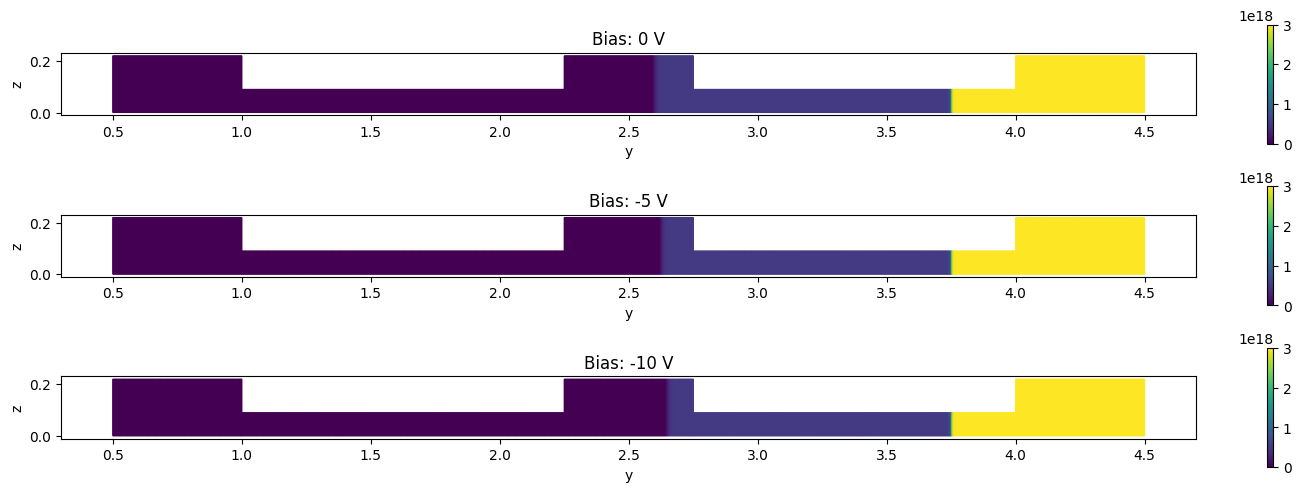

In [6]:
_, ax = plt.subplots(3, 1, figsize=(15, 5))

electrons_data[0].plot(grid=False, ax=ax[0])
electrons_data[10].plot(grid=False, ax=ax[1])
electrons_data[20].plot(grid=False, ax=ax[2])

ax[0].set_title("Bias: 0 V")
ax[1].set_title("Bias: -5 V")
ax[2].set_title("Bias: -10 V")

plt.tight_layout()
plt.show()

## Optic Simulations

Having obtained free carrier solutions in the modulator cross section we can now turn to setting up optic simulation that will use these results.

### Mediums with Charge Perturbations
First, we define optic mediums with charge perturbation models. For simplicity, we will use non-dispersive material descriptions. Thus, we start from obtaining permittivity and conductivity of Si at the wavelength of interest.

In [7]:
wvl_um = 1.55
freq0 = td.C_0 / wvl_um

si = td.material_library['cSi']['Li1993_293K']
n_si, k_si = si.nk_model(frequency=td.C_0/np.array(wvl_um))

# convert to permittivity and conductivity
permittivity_si, conductivity_si = td.Medium.nk_to_eps_sigma(n=n_si, k=k_si, freq=freq0)

We will use empiric relationships presented in [M. Nedeljkovic, R. Soref and G. Z. Mashanovich, "Free-Carrier Electrorefraction and Electroabsorption Modulation Predictions for Silicon Over the 1–14-  μm  Infrared Wavelength Range," IEEE Photonics Journal, vol. 3, no. 6, pp. 1171-1180, Dec. 2011](https://doi.org/10.1109/JPHOT.2011.2171930), that state that changes in $n$ and $k$ of Si can be described by formulas
$$ - \Delta n = \frac{dn}{dN_e}(\lambda) (\Delta N_e)^{\alpha(\lambda)} + \frac{dn}{dN_h}(\lambda) (\Delta N_h)^{\beta(\lambda)}$$
$$ \Delta \left( \frac{4 \pi k}{\lambda} \right) = \frac{dk}{dN_e}(\lambda) (\Delta N_e)^{\gamma(\lambda)} + \frac{dk}{dN_h}(\lambda) (\Delta N_h)^{\delta(\lambda)}$$
where $\Delta N_e$ and $\Delta N_h$ are electron and hole densities, and parameters have the following values for wavelength of 1.55 $\mu$m:

| $\lambda$ | $\frac{dn}{dN_e}$ | $\alpha$ | $\frac{dn}{dN_h}$ | $\beta$ | $\frac{dk}{dN_e}$ | $\gamma$ | $\frac{dk}{dN_h}$ | $\delta$ |
| --------- | ----------------- | ------- | ------------------ | ------- | ----------------- | -------- | ----------------- | -------- |
| $1.55$ | $5.40 \times 10^{-22}$ | $1.011$ | $1.53 \times 10^{-18}$ | $0.838$ | $8.88 \times 10^{-21}$ | $1.167$ | $5.84 \times 10^{-20}$ | $1.109$ | 

In [8]:
wvl_si_data = 1.55

ne_coeff = -5.4e-22
ne_pow = 1.011

nh_coeff = -1.53e-18
nh_pow = 0.838

k_factor = wvl_si_data * 1e-4 / 4 / np.pi  # factor for conversion from absorption coefficient into k

ke_coeff = k_factor * 8.88e-21
ke_pow = 1.167

kh_coeff = k_factor * 5.84e-20
kh_pow = 1.109

Given the nonlinear character of these dependencies we will incorporate them as sampled function on a rectangular grid formed by electron and hole density values. Specifically, we will sample given $n$ and $k$ dependencies in the electron and hole density ranges up to $10^{20}$ 1/cm$^3$.

In [9]:
Ne_range = np.concatenate(([0], np.logspace(15, 20, 20)))
Nh_range = np.concatenate(([0], np.logspace(15, 20, 21)))

Ne_mesh, Nh_mesh = np.meshgrid(Ne_range, Nh_range, indexing='ij')

wvl_ind = 1

n_mesh = n_si + ne_coeff * Ne_mesh ** ne_pow + nh_coeff * Nh_mesh ** nh_pow
k_mesh = k_si + ke_coeff * Ne_mesh ** ke_pow + kh_coeff * Nh_mesh ** kh_pow

Now we convert sampled values of $n$ and $k$ into permittivity $\varepsilon$ and conductivity $\sigma$ values, and assemble a non-dispersive medium with perturbations (`PerturbationMedium`).

In [10]:
eps_mesh, sigma_mesh = td.Medium.nk_to_eps_sigma(n=n_mesh, k=k_mesh, freq=freq0)

deps_data = td.ChargeDataArray(eps_mesh - permittivity_si, coords=dict(n=Ne_range, p=Nh_range))
dsigma_data = td.ChargeDataArray(sigma_mesh - conductivity_si, coords=dict(n=Ne_range, p=Nh_range))

permittivity_si_charge = td.CustomChargePerturbation(perturbation_values=deps_data)
conductivity_si_charge = td.CustomChargePerturbation(perturbation_values=dsigma_data)

permittivity_si_perturbation = td.ParameterPerturbation(
    charge=permittivity_si_charge,
)

conductivity_si_perturbation = td.ParameterPerturbation(
    charge=conductivity_si_charge,
)

si_perturb = td.PerturbationMedium(
    permittivity=permittivity_si,
    conductivity=conductivity_si,
    permittivity_perturbation=permittivity_si_perturbation,
    conductivity_perturbation=conductivity_si_perturbation,
)

Additionally, we define medium for undoped Si regions and for SiO2 BOX/cladding.

In [11]:
si_non_perturb = td.Medium(
    permittivity=permittivity_si,
    conductivity=conductivity_si,
)

sio2 = td.Medium(permittivity=1.444 ** 2)

### Circuits Structures
For generating the entire circuit we use helper functions for creating a single waveguide and a single coupler from tutorial [](). We make one modification in `directional_coupler()` to allow in and out waveguides to have different lengths.

In [12]:
def taper_waveguide(
    x0, y0, z0, x1, y1, wg_width_0, wg_width_1, wg_thickness, medium, sidewall_angle=0
):
    """
    This function defines a linear waveguide taper and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of the waveguide starting position (um)
    y0: y coordinate of the waveguide starting position (um)
    z0: z coordinate of the waveguide starting position (um)
    x1: x coordinate of the waveguide end position (um)
    y1: y coordinate of the waveguide end position (um)
    wg_width_0: width of the waveguide in the beginning (um)
    wg_width_1: width of the waveguide in the end (um)
    wg_thickness: thickness of the waveguide (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """
    cell = gdstk.Cell("taper")  # define a gds cell

    path = gdstk.RobustPath((x0, y0), wg_width_0, layer=1, datatype=0)  # define a path
    path.segment((x1, y1), wg_width_1)

    cell.add(path)  # add path to the cell

    # define geometry from the gds cell
    taper_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    taper = td.Structure(geometry=taper_geo[0], medium=medium)

    return taper
    
def directional_coupler(
    x0,
    y0,
    z0,
    wg_width,
    wg_thickness,
    wg_spacing_in,
    wg_spacing_coup,
    wg_length_in,
    wg_length_out,
    coup_length,
    bend_length,
    medium,
    sidewall_angle=0,
):

    """
    This function defines a directional coupler and returns the tidy3d structure of it.

    Parameters
    ----------
    x0: x coordinate of directional coupler center (um)
    y0: y coordinate of directional coupler center (um)
    z0: z coordinate of directional coupler center (um)
    wg_width: width of the waveguide (um)
    wg_thickness: thickness of the waveguide (um)
    wg_spacing_in : spacing between the input straight waveguides (um)
    wg_spacing_coup: gap size of the coupling region (um)
    wg_length_in: length of the input straight waveguides (um)
    wg_length_out: length of the input straight waveguides (um)
    coup_length：length of the coupling region (um)
    bend_length: length of the bending (um)
    medium: medium of the waveguide
    sidewall_angle: side wall angle of the waveguide (rad)
    """

    cell = gdstk.Cell("dc")  # define a gds cell

    # define a path
    coup = gdstk.RobustPath(
        (-wg_length_in - bend_length - coup_length / 2 + x0, wg_spacing_in / 2 + y0),
        wg_width,
        layer=1,
        datatype=0,
    )

    coup.segment((-bend_length - coup_length / 2 + x0, wg_spacing_in / 2 + y0))

    A = (wg_spacing_in - wg_spacing_coup - wg_width) / 4

    coup.segment(
        (-coup_length / 2 + x0, wg_spacing_in / 2 + y0), offset=lambda u: A * np.cos(np.pi * u) - A
    )

    coup.segment((coup_length / 2 + x0, wg_spacing_in / 2 + y0))

    coup.segment(
        (bend_length + coup_length / 2 + x0, wg_spacing_in / 2 + y0),
        offset=lambda u: -A * np.cos(np.pi * u) - A,
    )
    coup.segment((wg_length_out + bend_length + coup_length / 2 + x0, wg_spacing_in / 2 + y0))

    # add path to the cell
    cell.add(coup)

    # add the mirrored path to the cell
    cell.add(coup.copy().mirror((x0 + 1, y0), (x0, y0)))

    # define geometry from the gds cell
    dc_geo = td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(z0 - wg_thickness / 2, z0 + wg_thickness / 2),
        sidewall_angle=sidewall_angle,
    )

    # define tidy3d structure of the bend
    dc = td.Structure(geometry=td.GeometryGroup(geometries=dc_geo), medium=medium)

    return dc

Now we need to create necessary components. Note that we use the medium with perturbation models only for the modulator structures (`wg_top`, `slab_wg`, `side_top`, `side_bottom`) as the rest of the structures are assumed to be undoped. Splitter, combiner, and the bottom arm of the interferometer can simply be defined as.

In [13]:
# input coupler
coupler_in = directional_coupler(
    x0=-x_splitter,
    y0=0,
    z0=z_core,
    wg_width=w_core,
    wg_thickness=h_core,
    wg_spacing_in=wg_spacing,
    wg_spacing_coup=couple_gap,
    wg_length_in=couple_wg_in,
    wg_length_out=couple_wg_out,
    coup_length=couple_length,
    bend_length=bend_length,
    medium=si_non_perturb,
    sidewall_angle=0,
)

# output coupler
coupler_out = directional_coupler(
    x0=x_splitter,
    y0=0,
    z0=z_core,
    wg_width=w_core,
    wg_thickness=h_core,
    wg_spacing_in=wg_spacing,
    wg_spacing_coup=couple_gap,
    wg_length_in=couple_wg_out,
    wg_length_out=couple_wg_in,
    coup_length=couple_length,
    bend_length=bend_length,
    medium=si_non_perturb,
    sidewall_angle=0,
)

# bottom arm
bot_arm = taper_waveguide(
    x0=-mzi_length / 2, 
    y0=-wg_spacing / 2, 
    z0=z_core, 
    x1=mzi_length / 2, 
    y1=-wg_spacing / 2, 
    wg_width_0=w_core, 
    wg_width_1=w_core, 
    wg_thickness=h_core, 
    medium=si_non_perturb,
    sidewall_angle=0
)

Definition of the top arm, which contains the modulator, is more involved.

In [14]:
def make_arm(y0: float):
    # taper in 
    wg_in = taper_waveguide(
        x0=-mzi_length / 2, 
        y0=y0, 
        z0=z_core, 
        x1=-wg_length / 2, 
        y1=y0, 
        wg_width_0=w_core, 
        wg_width_1=w_core, 
        wg_thickness=h_core, 
        medium=si_non_perturb,
        sidewall_angle=0
    )
    
    slab_in = taper_waveguide(
        x0=-mzi_length / 2, 
        y0=y0, 
        z0=z_slab, 
        x1=-wg_length / 2, 
        y1=y0, 
        wg_width_0=w_core, 
        wg_width_1=2 * x_side, 
        wg_thickness=h_slab, 
        medium=si_non_perturb,
        sidewall_angle=0
    )
    
    # modulator
    slab = taper_waveguide(
        x0=-wg_length / 2, 
        y0=y0, 
        z0=z_slab, 
        x1=wg_length / 2, 
        y1=y0, 
        wg_width_0=2 * x_side, 
        wg_width_1=2 * x_side, 
        wg_thickness=h_slab, 
        medium=si_perturb,
        sidewall_angle=0
    )
    
    wg = taper_waveguide(
        x0=-wg_length / 2, 
        y0=y0, 
        z0=z_core, 
        x1=wg_length / 2, 
        y1=y0, 
        wg_width_0=w_core, 
        wg_width_1=w_core, 
        wg_thickness=h_core, 
        medium=si_perturb,
        sidewall_angle=0
    )
    
    y_side_top = y0 + x_side + (x_total - x_side) / 2
    y_side_bottom = y0 - x_side - (x_total - x_side) / 2
    
    side_top = taper_waveguide(
        x0=-wg_length / 2, 
        y0=y_side_top, 
        z0=z_side, 
        x1=wg_length / 2, 
        y1=y_side_top, 
        wg_width_0=x_total - x_side, 
        wg_width_1=x_total - x_side, 
        wg_thickness=h_side, 
        medium=si_perturb,
        sidewall_angle=0
    )
    
    side_bottom = taper_waveguide(
        x0=-wg_length / 2, 
        y0=y_side_bottom, 
        z0=z_side, 
        x1=wg_length / 2, 
        y1=y_side_bottom, 
        wg_width_0=x_total - x_side, 
        wg_width_1=x_total - x_side, 
        wg_thickness=h_side, 
        medium=si_perturb,
        sidewall_angle=0
    )
    
    # taper out 
    wg_out = taper_waveguide(
        x0=wg_length / 2, 
        y0=y0, 
        z0=z_core, 
        x1=mzi_length / 2, 
        y1=y0, 
        wg_width_0=w_core, 
        wg_width_1=w_core, 
        wg_thickness=h_core, 
        medium=si_non_perturb,
        sidewall_angle=0
    )
    
    slab_out = taper_waveguide(
        x0=wg_length / 2, 
        y0=y0, 
        z0=z_slab, 
        x1=mzi_length / 2, 
        y1=y0, 
        wg_width_0=2 * x_side, 
        wg_width_1=w_core, 
        wg_thickness=h_slab, 
        medium=si_non_perturb,
        sidewall_angle=0
    )

    return [wg_in, slab_in, wg, slab, side_top, side_bottom, wg_out, slab_out]

In [15]:
top_arm = make_arm(y0=wg_spacing / 2)

Before proceeding further into creating an optic simulation, we can combine created structures into a `Scene` object for visualization purposes.

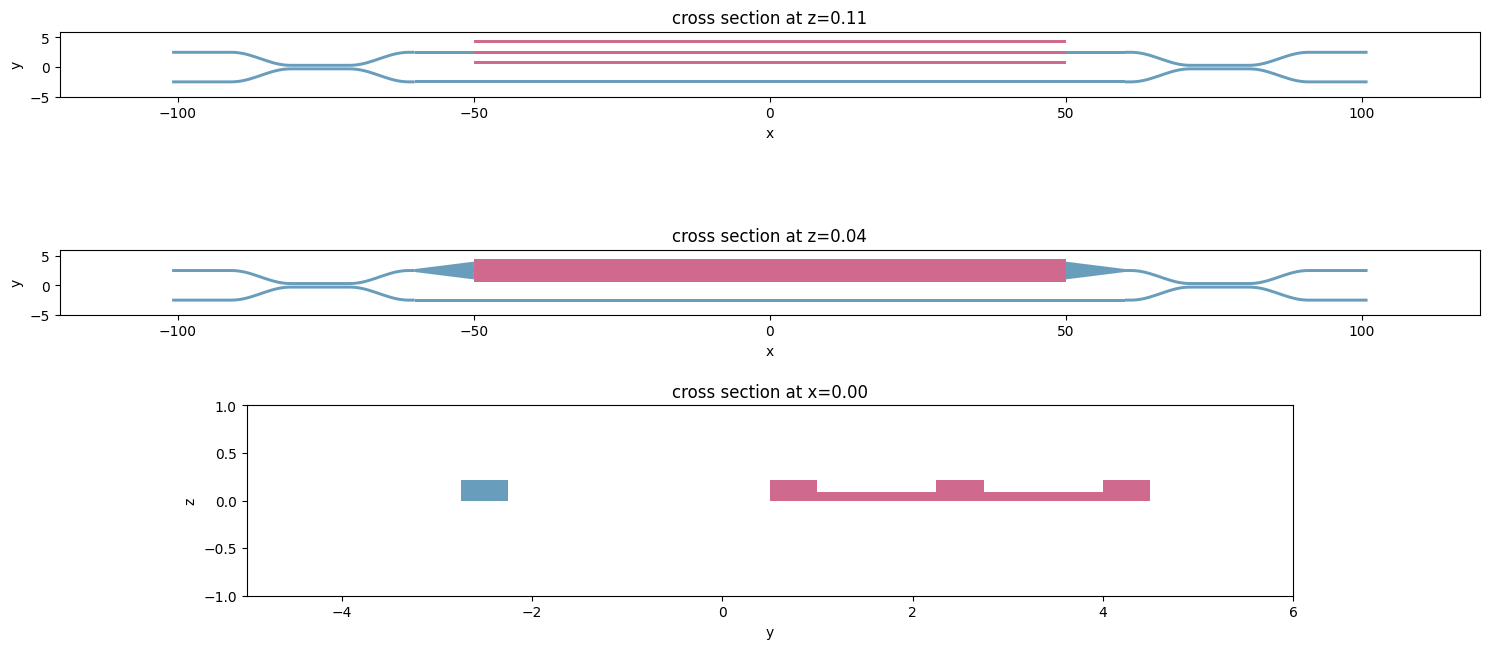

In [16]:
scene = td.Scene(
    structures=[coupler_in, coupler_out, bot_arm] + top_arm, 
    medium=sio2,
)

_, ax = plt.subplots(3, 1, figsize=(15, 7))
scene.plot(z=z_core, ax=ax[0], vlim=[-5, 6], hlim=[-120, 120])
scene.plot(z=z_slab, ax=ax[1], vlim=[-5, 6], hlim=[-120, 120])
scene.plot(x=0, ax=ax[2], vlim=[-1, 1], hlim=[-5, 6])

plt.tight_layout()
plt.show()

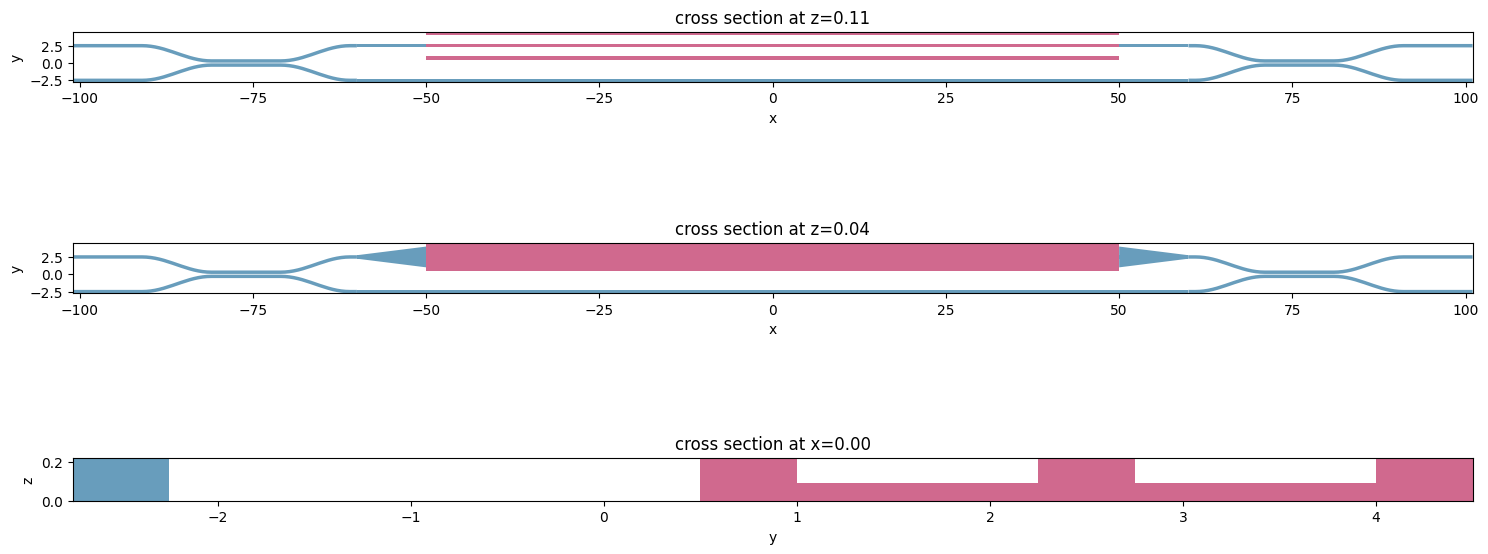

In [17]:
scene = td.Scene(
    structures=[coupler_in, coupler_out, bot_arm] + top_arm, 
    medium=sio2,
)

_, ax = plt.subplots(3, 1, figsize=(15, 7))
scene.plot(z=z_core, ax=ax[0])
scene.plot(z=z_slab, ax=ax[1])
scene.plot(x=0, ax=ax[2])

plt.tight_layout()
plt.show()


### Optic Sources and Monitors
Having inspected the geometry we now continue to define other component of an optic simulation. First, we define several auxiliary variables corresponding to:
- SiO2 buffer around the circuit,
- reduction of simulation in x direction,
- location and size of source injection and monitor ports,
- width of the injected pulse, and
- frequencies at which to measure output signals.

In [18]:
buffer = 1.3
dx = 8

port_x = mzi_length / 2 + 2 * couple_wg_out + 2 * bend_length + couple_length
port_y = wg_spacing / 2
port_z = z_core

port_size = (0, 3, 2)

fwidth = freq0 / 5
freqs = np.linspace(freq0 - fwidth / 10, freq0 + fwidth / 10, 201)

The propagation of EM pulse in the circuit is triggered by a `ModeSource`.

In [19]:
src = td.ModeSource(center=(-port_x, port_y, port_z), size=port_size, direction="+", mode_index=0, source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth))

We will measure mode decompositions in the input port and two output ports. Additionally, we will sample field distribution on the horizontal plane passing through the circuit's center.

In [20]:
mnt_in = td.ModeMonitor(center=(-port_x + 0.5, port_y, port_z), size=port_size, freqs=freqs, mode_spec=td.ModeSpec(num_modes=3), name="in")
mnt_out_top = td.ModeMonitor(center=(port_x, port_y, port_z), size=port_size, freqs=freqs, mode_spec=td.ModeSpec(num_modes=3), name="out_top")
mnt_out_bot = td.ModeMonitor(center=(port_x, -port_y, port_z), size=port_size, freqs=freqs, mode_spec=td.ModeSpec(num_modes=3), name="out_bot")
mnt_field = td.FieldMonitor(center=(0, 0, z_core), size=(td.inf, td.inf, 0), freqs=[freq0], name="field")

### Simulation Assembly

In [38]:
sim_size = (scene.size[0] - 2 * dx, scene.size[1] + 2 * buffer, scene.size[2] + 2 * buffer)
sim = td.Simulation(
    center=scene.center,
    size=sim_size,
    sources=[src],
    monitors=[mnt_in, mnt_out_top, mnt_out_bot, mnt_field],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15),
    structures=scene.structures,
    run_time=20 * 4 * 100 / td.C_0,
    shutoff=1e-8,
)

Let us perform another visual inspection to ensure the right placement of monitors and sources.

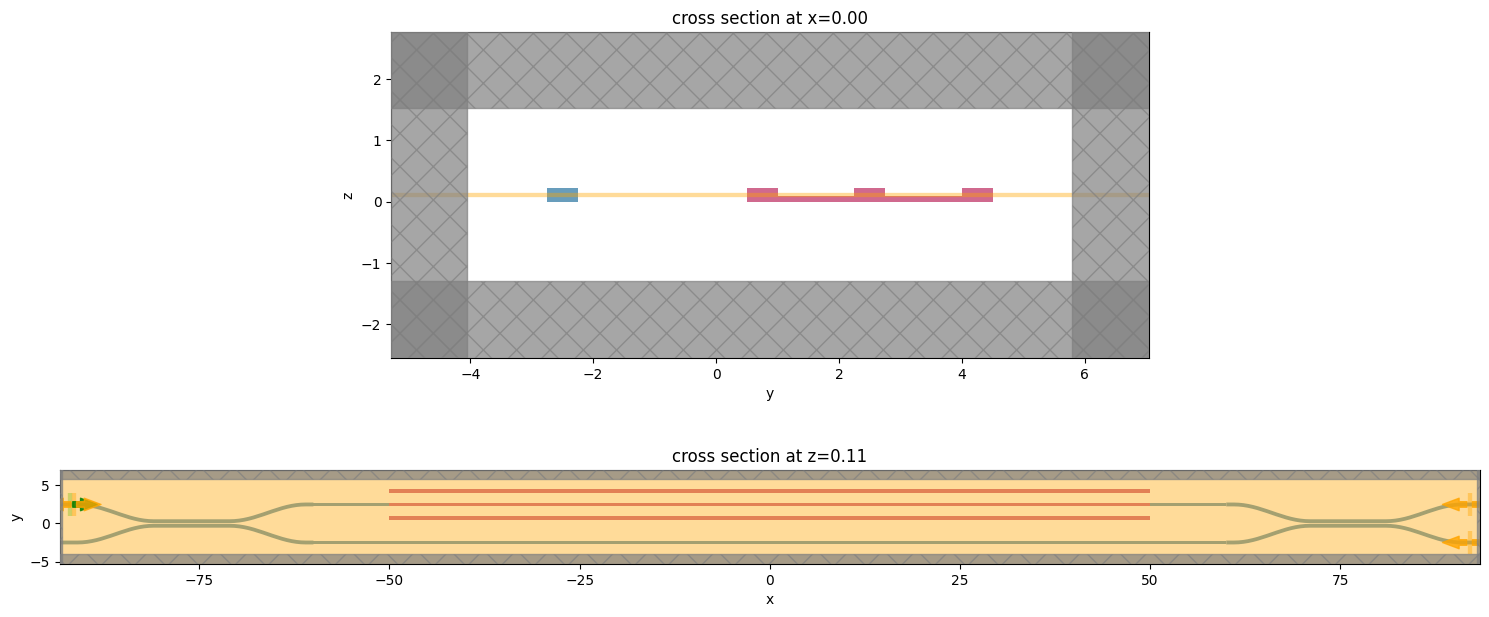

In [22]:
_, ax = plt.subplots(2, 1, figsize=(15, 7))
sim.plot(x=sim.center[0], ax=ax[0])
sim.plot(z=sim.center[2], ax=ax[1])

plt.tight_layout()
plt.show()

This can also be done using a three dimensional plotting functionality.

In [23]:
sim.plot_3d()

### Applying Carrier Distributions
At this point we have created an optic simulation that contains materials with charge perturbation models, however no electron and hole distribution have been provided to it. That is, when we submit such a simulation for solving, all mediums with perturbation models will be considered as regular materials with no perturbations applied. In our case, this corresponds to the case of undoped materials.

To obtain simulations in which perturbation models are sampled against provided carrier densities one can use a convenience method `.perturbed_mediums_copy()`. In the current Tidy3D version, one must provide carrier densities in the form of Cartesian arrays. Thus, we first define a Cartesian grid to transfer carrier distributions to based on the simulation grid without perturbations.

In [24]:
cs_grid = sim.discretize(box=td.Box.from_bounds(*electrons_data[0].bounds))

In [25]:
pert_sims = {}
for name, e_data, h_data in (
    ("bias_0", electrons_data[0], holes_data[0]),
    ("bias_5", electrons_data[10], holes_data[10]),
    ("bias_10", electrons_data[20], holes_data[20]),
):
    e_interpolated = e_data.interp(x=0, y=cs_grid.boundaries.y, z=cs_grid.boundaries.z, fill_value=0)
    h_interpolated = h_data.interp(x=0, y=cs_grid.boundaries.y, z=cs_grid.boundaries.z, fill_value=0)
    pert_sims[name] = sim.perturbed_mediums_copy(electron_density=e_interpolated, hole_density=h_interpolated)

The difference in the permittivity values in the modulator cross-section compared to the undoped case can be visualized as following.

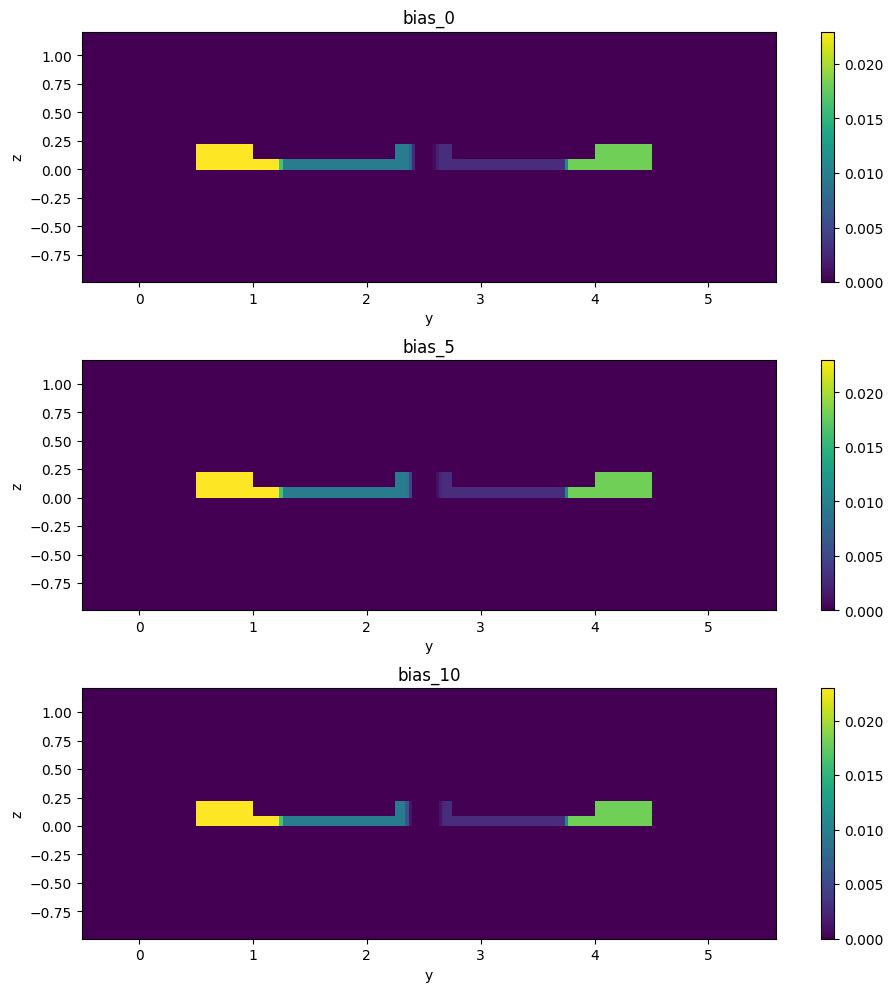

In [39]:
_, ax = plt.subplots(3, 1, figsize=(10, 10))
eps_undoped = sim.epsilon(box=td.Box(center=(0, port_y, port_z), size=(0, 6, 2)))

for ind, (key, psim) in enumerate(pert_sims.items()):
    eps_doped = pert_sims[key].epsilon(box=td.Box(center=(0, port_y, port_z), size=(0, 6, 2)))
    np.abs(eps_doped - eps_undoped).plot(x="y", ax=ax[ind])
    ax[ind].set_aspect("equal")
    ax[ind].set_title(key)

plt.tight_layout()
plt.show()

### Waveguide Mode Analysis

before proceeding to full-wave simulations one can investigate the influence of applied voltage on the propagation index of waveguide modes in the modulator.

In [28]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode

Let us define a plane for which waveguide modes will be calculated.

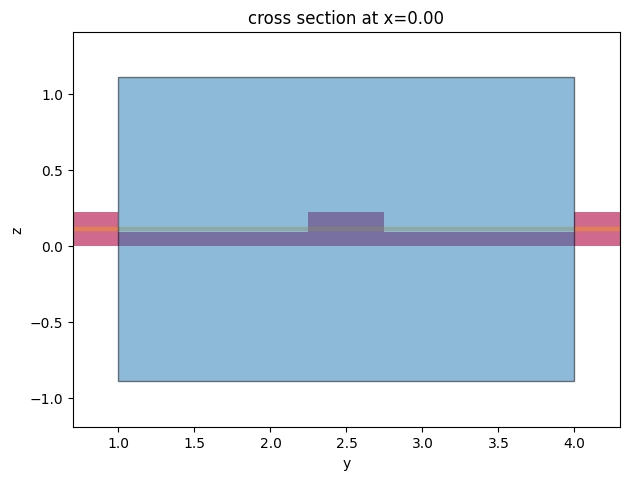

In [29]:
mode_plane = td.Box(center=(0, port_y, port_z), size=port_size)

# visualize
ax = sim.plot(x=mode_plane.center[0])
mode_plane.plot(x=mode_plane.center[0], ax=ax, alpha=0.5)
plt.show()

Create a mode solver specification for each carrier distribution. We will consider only the first mode at 11 different frequencies. Also, given that the anticipated changes are small, double precision is turned on for mode solving.

In [30]:
mode_solvers = {}
for key, sim in pert_sims.items():
    mode_solvers[key] = ModeSolver(
        simulation=sim,
        plane=mode_plane,
        freqs=np.linspace(freqs[0], freqs[-1], 11),
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
    )

Perform calculation on our servers. Note that since the associated simulation objects contain custom medium data, they are automatically reduced to the mode solver plane for optimizing uploading/downloading data.

In [31]:
ms_data = {}
for key, ms in mode_solvers.items():

    ms_data[key] = run_mode(ms)

00:36:52 CST WARNING: The associated `Simulation` object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             `Simulation` object use `reduce_simulation=False`. Setting         
             `reduce_simulation=True` will force simulation reduction in all    
             cases and silence this warning.                                    

00:36:53 CST Mode solver created with                                           
             task_id='fdve-2f52b106-8924-4c36-a372-9b41822dc332',               
             solver_id='mo-654c030a-c086-4d71-9dfa-57e3ed3627f3'.

Output()

Output()

00:36:59 CST Mode solver status: queued

00:37:16 CST Mode solver status: running

00:37:29 CST Mode solver status: success

Output()

00:37:30 CST WARNING: The associated `Simulation` object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             `Simulation` object use `reduce_simulation=False`. Setting         
             `reduce_simulation=True` will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-61eb47f4-301c-4985-8692-f8cf234c8abe',               
             solver_id='mo-8b1435aa-b4e2-4ab7-a3cb-8f29ebecef8e'.

Output()

Output()

00:37:32 CST Mode solver status: queued

00:37:48 CST Mode solver status: running

00:38:01 CST Mode solver status: success

Output()

00:38:02 CST WARNING: The associated `Simulation` object contains custom        
             mediums. It will be automatically restricted to the mode solver    
             plane to reduce data for uploading. To force uploading the original
             `Simulation` object use `reduce_simulation=False`. Setting         
             `reduce_simulation=True` will force simulation reduction in all    
             cases and silence this warning.                                    

             Mode solver created with                                           
             task_id='fdve-68d2554a-2f53-456c-863d-9f4385ce6cec',               
             solver_id='mo-4922acfe-4485-42c4-8edd-01133c138324'.

Output()

Output()

00:38:05 CST Mode solver status: queued

00:38:22 CST Mode solver status: running

00:38:35 CST Mode solver status: success

Output()

Now we can calculate the change in the effective propagation index due to applied voltage.

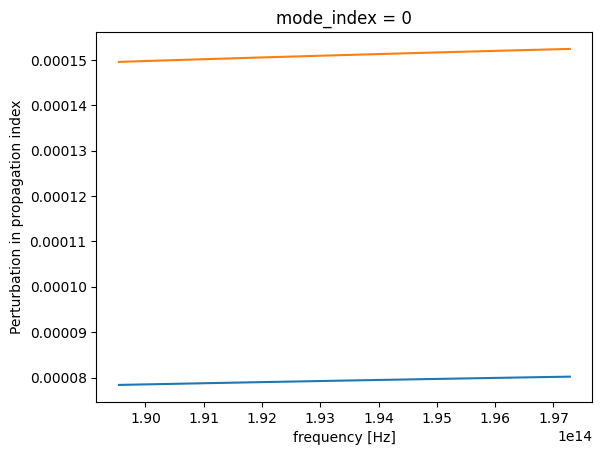

In [32]:
(ms_data["bias_5"].n_complex - ms_data["bias_0"].n_complex).abs.plot()
(ms_data["bias_10"].n_complex - ms_data["bias_0"].n_complex).abs.plot()
plt.ylabel("Perturbation in propagation index")
plt.show()

### Propagation through the Circuit

Let us now perform simulation of the entire MZI circuit for selected applied voltages. For convenience, we use `Batch` functionality.

In [33]:
batch = web.Batch(simulations=pert_sims)
batch_data = batch.run()

00:38:36 CST Created task 'bias_0' with task_id                                 
             'fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=593998;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=718888;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0\taskId]8;;\]8;id=593998;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0\=]8;;\]8;id=444226;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0\fdve]8;;\]8;id=593998;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0\-56d1e97a-1da]8;;\
             ]8;id=593998;https://tidy3d.simulation.cloud/workbench?taskId=fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0\8-40a4-844c-422f10efa7a0']8;;\.

Output()

00:38:37 CST Created task 'bias_5' with task_id                                 
             'fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=450638;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=141175;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e\taskId]8;;\]8;id=450638;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e\=]8;;\]8;id=532079;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e\fdve]8;;\]8;id=450638;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e\-8bbffe8c-921]8;;\
             ]8;id=450638;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e\2-4050-b59e-360d35ad7c3e']8;;\.

Output()

00:38:38 CST Created task 'bias_10' with task_id                                
             'fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=21730;https://tidy3d.simulation.cloud/workbench?taskId=fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=48841;https://tidy3d.simulation.cloud/workbench?taskId=fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd\taskId]8;;\]8;id=21730;https://tidy3d.simulation.cloud/workbench?taskId=fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd\=]8;;\]8;id=866961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd\fdve]8;;\]8;id=21730;https://tidy3d.simulation.cloud/workbench?taskId=fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd\-163ba12e-2ce]8;;\
             ]8;id=21730;https://tidy3d.simulation.cloud/workbench?taskId=fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd\5-486d-b459-1cc56bab5afd']8;;\.

Output()

00:38:41 CST Started working on Batch.

00:39:10 CST Maximum FlexCredit cost: 49.302 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

00:50:00 CST Batch complete.

Let us first visualize the field distribution across the whole circuit.

Output()

00:50:10 CST loading simulation from                                            
             ./fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0.hdf5

00:50:11 CST loading simulation from                                            
             ./fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0.hdf5

Output()

00:50:26 CST loading simulation from                                            
             ./fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e.hdf5

             loading simulation from                                            
             ./fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e.hdf5

Output()

00:50:42 CST loading simulation from                                            
             ./fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd.hdf5

             loading simulation from                                            
             ./fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd.hdf5

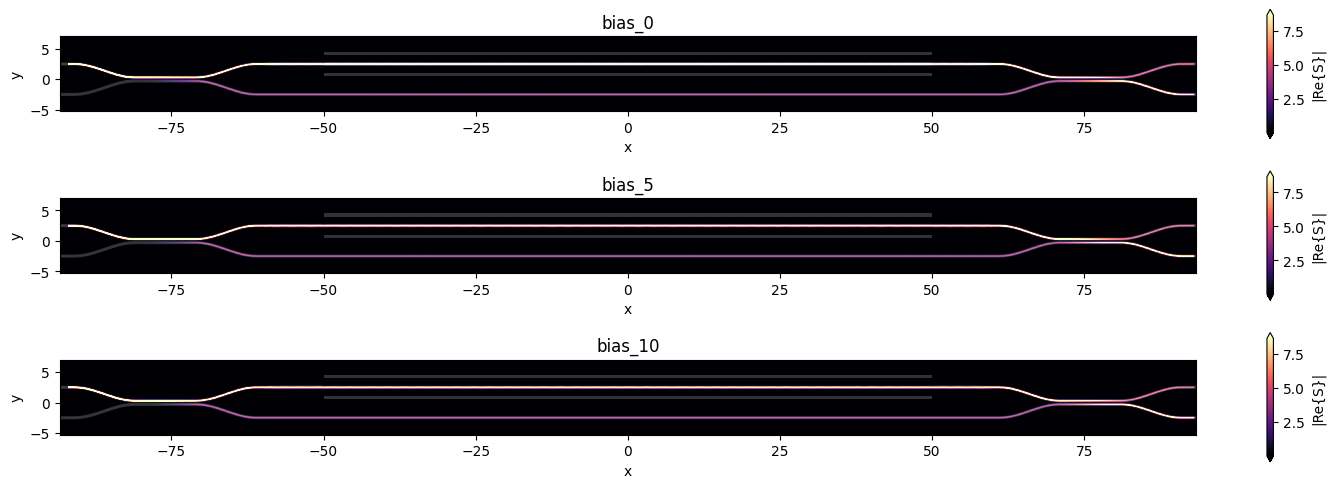

In [34]:
_, ax = plt.subplots(3, 1, figsize=(15, 5))

for ind, (key, data) in enumerate(batch_data.items()):
    batch_data[key].plot_field("field", "S", ax=ax[ind])
    ax[ind].set_title(key)

plt.tight_layout()
plt.show()

Due to a small effect of carrier depletion at selected applied voltages the differences in field distribution are hard to make out visually for a rather short circuit. The effect of phase shift is more clear in the mode decomposition plots for top and bottom output ports.

00:52:06 CST loading simulation from                                            
             ./fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0.hdf5

             loading simulation from                                            
             ./fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0.hdf5

00:52:07 CST loading simulation from                                            
             ./fdve-56d1e97a-1da8-40a4-844c-422f10efa7a0.hdf5

             loading simulation from                                            
             ./fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e.hdf5

             loading simulation from                                            
             ./fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e.hdf5

             loading simulation from                                            
             ./fdve-8bbffe8c-9212-4050-b59e-360d35ad7c3e.hdf5

             loading simulation from                                            
             ./fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd.hdf5

00:52:08 CST loading simulation from                                            
             ./fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd.hdf5

             loading simulation from                                            
             ./fdve-163ba12e-2ce5-486d-b459-1cc56bab5afd.hdf5

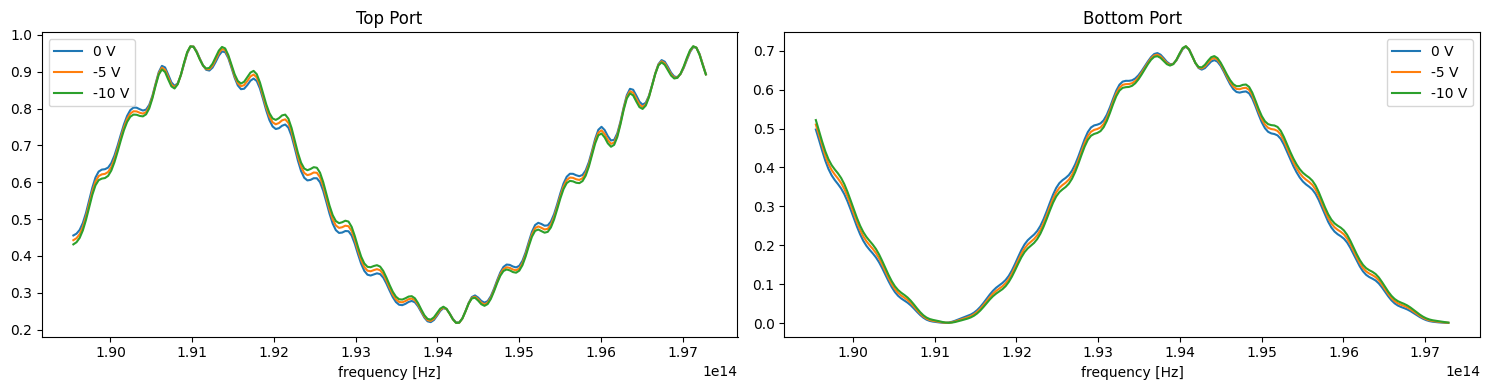

In [40]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
for ind, (key, data) in enumerate(batch_data.items()):
    (batch_data[key]["out_top"].amps.abs ** 2).sel(direction="+", mode_index=0).plot(ax=ax[0])
    (batch_data[key]["out_bot"].amps.abs ** 2).sel(direction="+", mode_index=0).plot(ax=ax[1])

ax[0].set_title("Top Port")
ax[0].legend(["0 V", "-5 V", "-10 V"])

ax[1].set_title("Bottom Port")
ax[1].legend(["0 V", "-5 V", "-10 V"])

plt.tight_layout()
plt.show()